In [1]:
from PIL import Image

from matplotlib.pyplot import *
%matplotlib inline

import numpy as np
import pandas as pd

import time

import collections

%load_ext autoreload
%autoreload 2

import processing

import math

In [2]:
ssh = None
processor_args = {}
decisionmaker_args = {}

In [3]:
master = processing.Master("./images/benchmark1/", ssh, delete=False, save=False, processor_args=processor_args, decisionmaker_args=decisionmaker_args)
master.run_local()
master.decisionmaker.balls_old = master.decisionmaker.balls

Not connecting sorter
('blue', 'blue_orange', 'green_orange', 'yellow', 'yellow_blue')
6179
>>  Receiving images ----------------------------------------
>>  Warm up ended -------------------------------------------


/run/media/wouters/WouterSSD/ballsorter/processing.py:190: RuntimeWarning: invalid value encountered in double_scalars
  rolling_fold = rolling_local/rolling_global


Ball is passing by...
Ball has passed...
deciding...
Sending gate 1
Ball is passing by...
Ball has passed...
deciding...
Sending gate 1
Ball is passing by...
Ball has passed...
deciding...
Sending gate 4
Ball is passing by...
Ball has passed...
deciding...
Sending gate 2
Ball is passing by...
Ball has passed...
deciding...
Sending gate 3
Ball is passing by...
Ball has passed...
deciding...
Sending gate 3
Ball is passing by...
Ball has passed...
deciding...
Sending gate 1
Ball is passing by...
Ball has passed...
deciding...
Sending gate 0
Ball is passing by...
Ball has passed...
deciding...
Sending gate 3
Ball is passing by...
Ball has passed...
deciding...
Sending gate 4
Ball is passing by...
Ball has passed...
deciding...
Sending gate 4
Ball is passing by...
Ball has passed...
deciding...
Sending gate 4
Ball is passing by...
Ball has passed...
deciding...
Sending gate 4
Ball is passing by...
Ball has passed...
deciding...
Sending gate 1
Ball is passing by...
Ball has passed...
decidin

In [4]:
master.decisionmaker.balls = master.decisionmaker.balls_old

In [5]:
## REMOVE BALLS, watch out!!
remove_balls = [6, 12, 17, 18, 19]
master.decisionmaker.balls = [master.decisionmaker.balls_old[i] for i in range(len(master.decisionmaker.balls_old)) if i not in remove_balls]

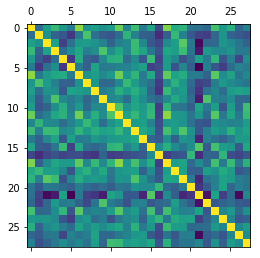

In [6]:
allbincounts = np.vstack([ball["bincounts"] for ball in master.decisionmaker.balls])
allbincounts = allbincounts[0:allbincounts.shape[0]-1, :]
balls = master.decisionmaker.balls[0:len(master.decisionmaker.balls)]

cors = np.corrcoef(allbincounts)
matshow(cors)

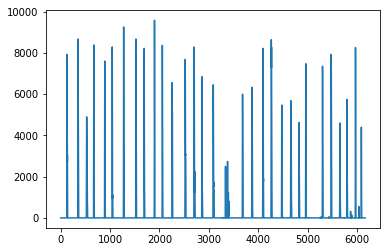

In [7]:
master.processor.log["rolling_local"].plot()

In [8]:
images = []

folder = master.processor.imagefolder
for ball in balls:
    ids = list(ball["ids"])
    i = ids[len(ids)//2]
    
    print(i)
    
    for j in range(i-4, i+4, 2):
        image = Image.open(folder + str(j) + ".jpg")
        images.append(image)

130
352
527
671
893
1044
1276
1526
1693
1900
2060
2526
2708
2864
3096
3686
3877
4100
4270
4481
4665
4830
4966
5307
5482
5657
5803
5973
6092


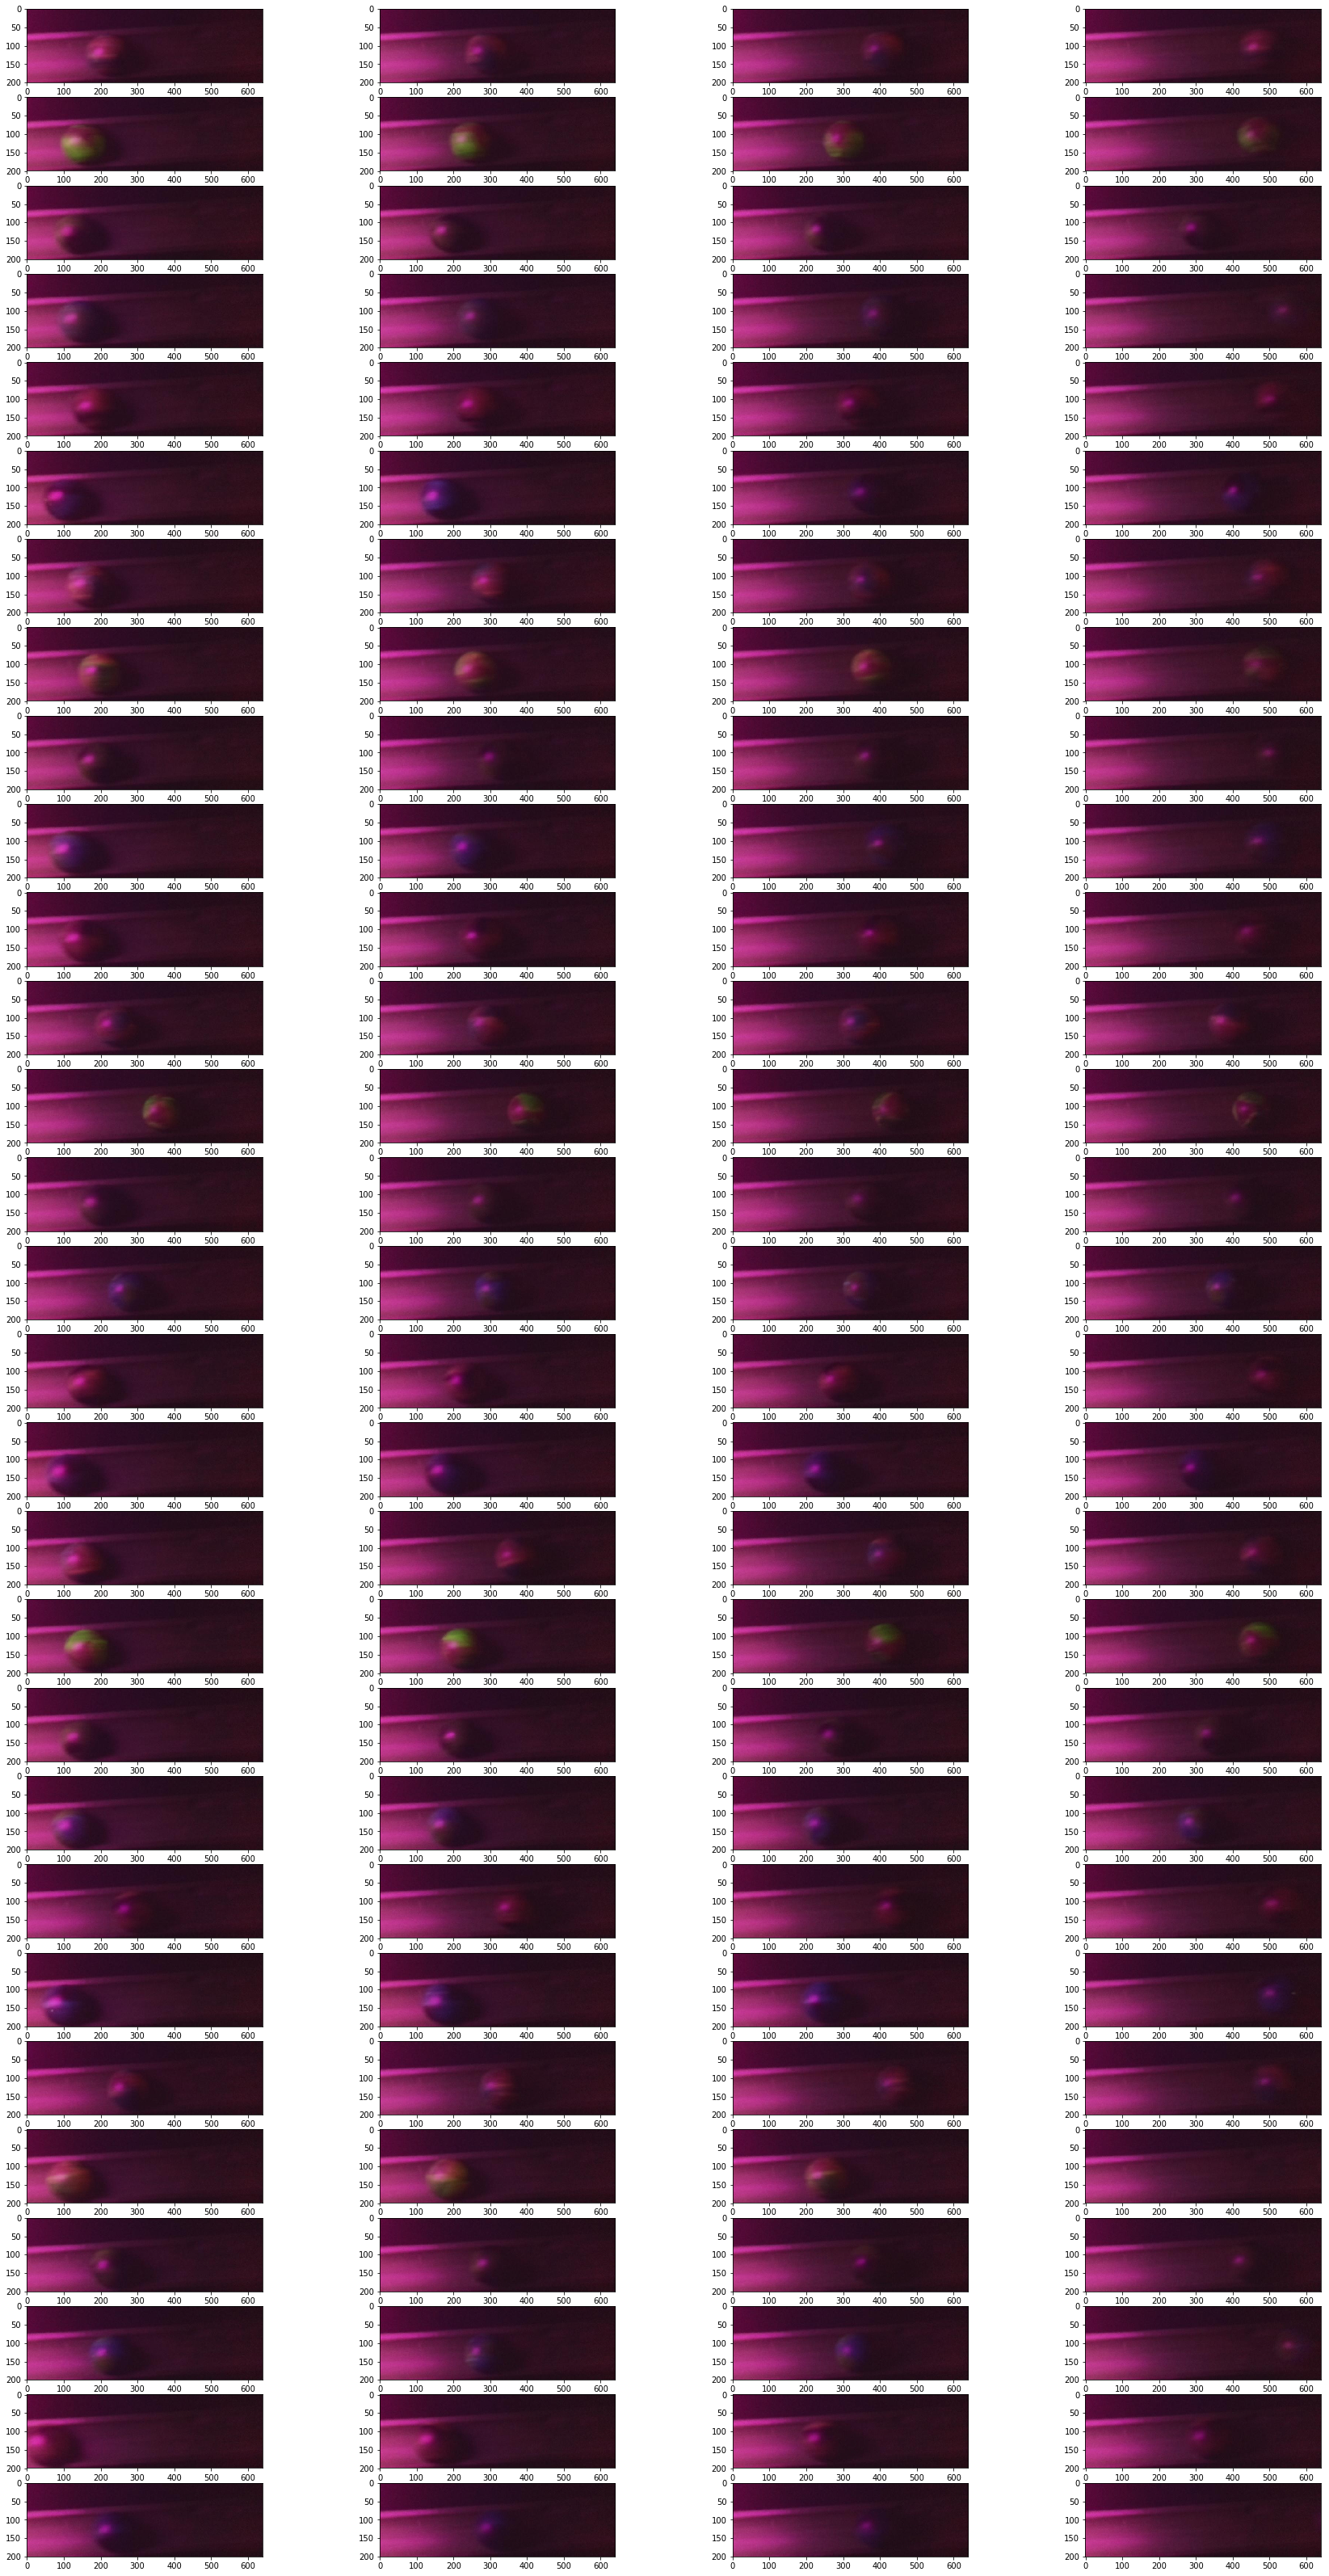

In [9]:
nrows = math.ceil(len(images) / 4)
ncols = 4
fig, axes = subplots(nrows=nrows, ncols=ncols, figsize=(30, nrows * 2))

for i, image in enumerate(images):
    axes[math.floor(i/ncols), i%ncols].imshow(np.array(image) / 255)

In [10]:
names = ["bo", "og", "y", "yb", "o", "b", "bo", "og", "y", "yb", "o", "bo", "og", "y", "yb", "o", "b", "bo", "og", "y", "yb", "o", "b", "bo", "og", "y", "yb", "o", "b"]
possible_names = ["bo", "og", "y", "yb", "o", "b"]

def label_img(name):
    label = np.zeros(len(possible_names))
    label[np.where([l == name for l in possible_names])[0]] = 1
    assert label.sum() == 1, name
    return label

In [11]:
IMG_WIDTH = 640
IMG_HEIGHT = 200
folder = master.processor.imagefolder
data = []
for name, ball in zip(names, balls):
    ids = list(ball["ids"])
    
    for j in ids:
        image = Image.open(folder + str(j) + ".jpg")
        data.append([np.array(image), label_img(name)])

In [12]:
import matplotlib.pyplot as plt

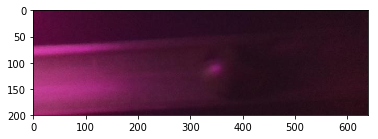

In [13]:
plt.imshow(data[40][0], cmap = 'gist_gray')

In [14]:
import keras
from keras.models import *
from keras.layers import *

Using TensorFlow backend.


In [15]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(len(possible_names), activation = 'softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
train_ix = np.random.choice(range(len(data)), int(len(data)/2))
test_ix = [i for i in range(len(data)) if i not in train_ix]

In [17]:
train_images = np.array([d[0] for d in data])[train_ix, ]#.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
train_labels = np.array([d[1] for d in data])[train_ix, ]

test_images = np.array([d[0] for d in data])[test_ix, ]#.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
test_labels = np.array([d[1] for d in data])[test_ix, ]

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [19]:
model.fit(train_images, train_labels, batch_size = 50, epochs = 10, verbose = 1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
198/198 [==============================] - 31s 158ms/step - loss: 0.5180 - acc: 0.8165
Epoch 2/10
198/198 [==============================] - 31s 159ms/step - loss: 0.3975 - acc: 0.8392
Epoch 3/10
198/198 [==============================] - 30s 152ms/step - loss: 0.3209 - acc: 0.8687
Epoch 4/10
198/198 [==============================] - 29s 148ms/step - loss: 0.2696 - acc: 0.8855
Epoch 5/10
198/198 [==============================] - 32s 161ms/step - loss: 0.2012 - acc: 0.9116
Epoch 6/10
198/198 [==============================] - 30s 153ms/step - loss: 0.1556 - acc: 0.9369
Epoch 7/10
198/198 [==============================] - 29s 147ms/step - loss: 0.1177 - acc: 0.9621
Epoch 8/10
198/198 [==============================] - 31s 159ms/step - loss: 0.0872 - acc: 0.9764
Epoch 9/10
198/198 [==============================] - 31s 155ms/step - loss: 0.0526 - acc: 0.9823
Epoch 10/10
198/198 [==============================] - 34s 173ms/step 

In [20]:
train_predictions = model.predict(train_images)
test_predictions = model.predict(test_images)

In [21]:
score, acc = model.evaluate(
    test_images,
    test_labels
)

250/250 [==============================] - 11s 44ms/step


array([4])

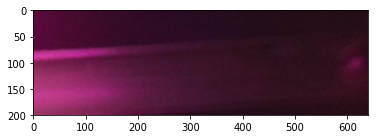

In [64]:
image_ix = 144
plt.imshow(test_images[image_ix, ], cmap = 'gist_gray')
pd.DataFrame({"predicted":test_predictions[image_ix, ], "actual":test_labels[image_ix, ]}, index = possible_names)
model.predict_classes(test_images[image_ix:image_ix+1,])

In [85]:
np.expand_dims(test_images[image_ix, ], 0).shape

(1, 200, 640, 3)

In [80]:
model.predict(test_images[image_ix:image_ix+1,])[0]

array([0.04360045, 0.00306797, 0.02824152, 0.00202854, 0.5451028 ,
       0.37795883], dtype=float32)

In [75]:
import pickle
pickle.dump(model, open("cnn_model.pkl", "wb"))

In [78]:
model = pickle.load(open("cnn_model.pkl", "rb"))